## Notebook to create a regional rainfall-runoff model using an LSTM network

**Description**

The following notebook contains the code to create, train, validate and test a rainfall-runoff model using a LSTM 
network architecture. The code allows for the creation of single-basin models (by specifying the entity_id rather than a path to a text file), but it is conceptualized to create 
regional models. The code is intended as an intial introduction to the topic, in which we prioritized interpretability
over modularity.

The logic of the code is heavily based on [Neural Hydrology](https://doi.org/10.21105/joss.04050)[1]. For a more 
flexible, robust and modular implementation of deep learning method in hydrological modeling we advice the use of Neural 
Hydrology. 

The code is compatible with all the original caravan datasets (camelsgb, camelsaus, camelsbr, camelscl, camelsgb, hysets, lamah) and the caravan community extensions (tested only for the GRDC extension).

**Authors:**
- Ashish Manoj J
- Eduardo Acuna Espinoza
- Ralf Loritz
- Manuel Álvarez Chaves

**References:**

[1]: "F. Kratzert, M. Gauch, G. Nearing and D. Klotz: NeuralHydrology -- A Python library for Deep Learning research in hydrology. Journal of Open Source Software, 7, 4050, doi: 10.21105/joss.04050, 2022"

In [1]:
#Import necessary packages
import sys
import pandas as pd
import numpy as np
import time
import pickle
import random
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

sys.path.append("../aux_functions")
sys.path.append("../datasetzoo")
sys.path.append("../modelzoo")

# Import classes and functions from other files
from functions_training import nse_basin_averaged
from functions_evaluation import nse
from functions_aux import create_folder, set_random_seed, write_report

# Import dataset to use
from caravan import CARAVAN

# Import model
from cudalstm import CudaLSTM

Part 1. Initialize information

In [2]:
# Define experiment nae
experiment_name = "LSTM_CARAVAN"

# paths to access the information
path_entities = "../../data/basin_id/basins_grdc_trial.txt"
path_data = '/pfs/data5/home/kit/iwu/as2023/dataset/01_europe_flood/Caravan/' # Caution! using absolute path here as I do not want to save the large caravan dataset together with the code. This should be suitably adjusted.

# dynamic forcings and target
dynamic_input = ['total_precipitation_sum', 'temperature_2m_mean', 'volumetric_soil_water_layer_2_mean']
target = ['streamflow']

# static attributes that will be used
static_input = ['area', 'p_mean','ele_mt_sav','frac_snow']

# time periods
training_period = ["1985-10-01","1997-12-31"]
validation_period = ["1982-10-01","1984-09-30"]
testing_period = ["1998-01-01","2008-12-31"]

model_hyper_parameters = {
    "input_size_lstm": len(dynamic_input) + len(static_input),
    "no_of_layers":1,  
    "seq_length": 365,
    "hidden_size": 64,
    "batch_size_training":256,
    "batch_size_evaluation":1024,
    "no_of_epochs": 20,             
    "drop_out_rate": 0.4, 
    "learning_rate": 0.001,
    "adapt_learning_rate_epoch": 10,
    "adapt_gamma_learning_rate": 0.5,
    "set_forget_gate":3,
    "validate_every": 1,
    "validate_n_random_basins": -1
    }

# device to train the model
running_device = "gpu" #cpu or gpu

# define random seed
seed = 42

# colorblind friendly palette for plotting
color_palette = {"observed": "#1f78b4","simulated": "#ff7f00"}

In [3]:
# Create folder to store the results
path_save_folder = "../results/"+experiment_name
create_folder(folder_path=path_save_folder)

Folder '../results/LSTM_CARAVAN' already exists.


In [4]:
# check if model will be run in gpu or cpu and define device
if running_device == "gpu":
    print(torch.cuda.get_device_name(0))
    device= f'cuda:0'
elif running_device == "cpu":
    device = "cpu"

Tesla V100-SXM2-32GB


Part 2. Create dataset and dataloader for training

In [5]:
# Dataset training
training_dataset = CARAVAN(dynamic_input= dynamic_input,
                             target= target, 
                             sequence_length= model_hyper_parameters["seq_length"],
                             time_period= training_period,
                             path_data= path_data,
                             path_entities= path_entities,
                             static_input= static_input,
                             check_NaN= True)

training_dataset.calculate_basin_std()
training_dataset.calculate_global_statistics(path_save_scaler=path_save_folder)
training_dataset.standardize_data()

In [6]:
# Dataloader training
train_loader = DataLoader(dataset = training_dataset, 
                          batch_size = model_hyper_parameters["batch_size_training"],
                          shuffle = True,
                          drop_last = True)

print("Batches in training: ", len(train_loader))
sample = next(iter(train_loader))
print(f'x_lstm: {sample["x_lstm"].shape} | y_obs: {sample["y_obs"].shape} | basin_std: {sample["basin_std"].shape}')

Batches in training:  123
x_lstm: torch.Size([256, 365, 7]) | y_obs: torch.Size([256, 1, 1]) | basin_std: torch.Size([256, 1, 1])


Part 3. Create dataset for validation

In [7]:
# We will create an individual dataset per basin. This will give us more flexibility
entities_ids = np.loadtxt(path_entities, dtype="str").tolist()
validation_dataset = {}

for entity in entities_ids:
    dataset = CARAVAN(dynamic_input= dynamic_input,
                        target= target, 
                        sequence_length= model_hyper_parameters["seq_length"],
                        time_period= validation_period,
                        path_data= path_data,
                        entity= entity,
                        static_input= static_input,
                        check_NaN= False)
    
    dataset.scaler = training_dataset.scaler
    dataset.standardize_data(standardize_output=False)
    validation_dataset[entity]= dataset

In [ ]:
#Incase of cuDNN Compatibility error in the cluster reintsall pytorch 
!pip install torch

Part 4. Train LSTM

In [10]:
# construct model
set_random_seed(seed=seed)
lstm_model = CudaLSTM(hyperparameters=model_hyper_parameters).to(device)

# optimizer
optimizer = torch.optim.Adam(lstm_model.parameters(),
                             lr=model_hyper_parameters["learning_rate"])
    
# define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=model_hyper_parameters["adapt_learning_rate_epoch"],
                                            gamma=model_hyper_parameters["adapt_gamma_learning_rate"])

# set forget gate to 3 to ensure that the model is capable to learn long term dependencies
lstm_model.lstm.bias_hh_l0.data[model_hyper_parameters["hidden_size"]:2 * model_hyper_parameters["hidden_size"]]=\
    model_hyper_parameters["set_forget_gate"]

training_time = time.time()
# Loop through the different epochs
for epoch in range(1, model_hyper_parameters["no_of_epochs"]+1):
    
    epoch_start_time = time.time()
    total_loss = []
    # Training -------------------------------------------------------------------------------------------------------
    lstm_model.train()
    for sample in train_loader: 
        optimizer.zero_grad() # sets gradients of weigths and bias to zero
        pred  = lstm_model(sample["x_lstm"].to(device)) # forward call
        
        loss = nse_basin_averaged(y_sim=pred["y_hat"], 
                                  y_obs=sample["y_obs"].to(device), 
                                  per_basin_target_std=sample["basin_std"].to(device))
        
        loss.backward() # backpropagates
        torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), 1) #clip gradients
        optimizer.step() #update weights
        total_loss.append(loss.item())
        
        # remove from cuda
        del sample["x_lstm"], sample["y_obs"], sample["basin_std"], pred
        torch.cuda.empty_cache()
        
    #training report  
    report = f'Epoch: {epoch:<2} | Loss training: {"%.3f "% (np.mean(total_loss))}'
    
    # Validation -----------------------------------------------------------------------------------------------------
    if epoch % model_hyper_parameters["validate_every"] == 0:
        lstm_model.eval()
        validation_results = {}
        with torch.no_grad():
            # If we define validate_n_random_basins as 0 or negative, we take all the basins
            if model_hyper_parameters["validate_n_random_basins"] <= 0:
                validation_basin_ids = validation_dataset.keys()
            else:
                keys = list(validation_dataset.keys())
                validation_basin_ids = random.sample(keys, model_hyper_parameters["validate_n_random_basins"])
            
            # go through each basin that will be used for validation
            for basin in validation_basin_ids:
                loader = DataLoader(dataset=validation_dataset[basin], 
                                    batch_size=model_hyper_parameters["batch_size_evaluation"], 
                                    shuffle=False, 
                                    drop_last = False)
                
                df_ts = pd.DataFrame()
                for sample in loader:
                    pred  = lstm_model(sample["x_lstm"].to(device)) 
                    # backtransformed information
                    y_sim = pred["y_hat"]* validation_dataset[basin].scaler["y_std"].to(device) +\
                        validation_dataset[basin].scaler["y_mean"].to(device)

                    # join results in a dataframe and store them in a dictionary (is easier to plot later)
                    df = pd.DataFrame({"y_obs": sample["y_obs"].flatten().cpu().detach(), 
                                       "y_sim": y_sim.flatten().cpu().detach()}, 
                                      index=pd.to_datetime(sample["date"]))

                    df_ts = pd.concat([df_ts, df], axis=0)

                    # remove from cuda
                    del pred, y_sim
                    torch.cuda.empty_cache()       
                
                validation_results[basin] = df_ts
                 
            #average loss validation
            loss_validation = nse(df_results=validation_results)
            report += f'| Loss validation: {"%.3f "% (loss_validation)}'

    
    # save model after every epoch
    path_saved_model = path_save_folder+"/epoch_" + str(epoch)
    torch.save(lstm_model.state_dict(), path_saved_model)
            
    # print epoch report
    report += f'| Epoch time: {"%.1f "% (time.time()-epoch_start_time)} s | LR:{"%.5f "% (optimizer.param_groups[0]["lr"])}'
    print(report)
    write_report(file_path=path_save_folder+"/run_progress.txt", text=report)
    # modify learning rate
    scheduler.step()

# print final report
report = f'Total training time: {"%.1f "% (time.time()-training_time)} s'
print(report)
write_report(file_path=path_save_folder+"/run_progress.txt", text=report)   

Epoch: 1  | Loss training: 0.319 | Loss validation: 0.279 | Epoch time: 5.8  s | LR:0.00100 
Epoch: 2  | Loss training: 0.232 | Loss validation: 0.436 | Epoch time: 4.7  s | LR:0.00100 
Epoch: 3  | Loss training: 0.197 | Loss validation: 0.531 | Epoch time: 4.7  s | LR:0.00100 
Epoch: 4  | Loss training: 0.174 | Loss validation: 0.595 | Epoch time: 4.7  s | LR:0.00100 
Epoch: 5  | Loss training: 0.160 | Loss validation: 0.608 | Epoch time: 4.7  s | LR:0.00100 
Epoch: 6  | Loss training: 0.148 | Loss validation: 0.597 | Epoch time: 4.7  s | LR:0.00100 
Epoch: 7  | Loss training: 0.144 | Loss validation: 0.631 | Epoch time: 4.7  s | LR:0.00100 
Epoch: 8  | Loss training: 0.139 | Loss validation: 0.654 | Epoch time: 4.7  s | LR:0.00100 
Epoch: 9  | Loss training: 0.132 | Loss validation: 0.640 | Epoch time: 4.8  s | LR:0.00100 
Epoch: 10 | Loss training: 0.128 | Loss validation: 0.632 | Epoch time: 4.7  s | LR:0.00100 
Epoch: 11 | Loss training: 0.119 | Loss validation: 0.688 | Epoch time

Part 5. Test LSTM

In [ ]:
# In case I already trained an LSTM I can re-construct the model
#lstm_model = CudaLSTM(hyperparameters=model_hyper_parameters).to(device)
#lstm_model.load_state_dict(torch.load(path_save_folder + "/epoch_20", map_location=device))

In [11]:
# We will create an individual dataset per basin. This will give us more flexibility
#path_entities = "../../data/basin_id/basins_camels_gb_lees.txt"
entities_ids = np.loadtxt(path_entities, dtype="str").tolist()
testing_dataset = {}

# We can read a previously stored scaler or use the one from the training dataset we just generated
#scaler = training_dataset.scaler
with open(path_save_folder + "/scaler.pickle", "rb") as file:
    scaler = pickle.load(file)

for entity in entities_ids:
    dataset = CARAVAN(dynamic_input= dynamic_input,
                        target= target, 
                        sequence_length= model_hyper_parameters["seq_length"],
                        time_period= testing_period,
                        path_data= path_data,
                        entity= entity,
                        static_input= static_input,
                        check_NaN= False)
    
    dataset.scaler = scaler
    dataset.standardize_data(standardize_output=False)
    testing_dataset[entity]= dataset

In [12]:
lstm_model.eval()
test_results = {}
with torch.no_grad():
    for basin, dataset in testing_dataset.items():
        loader = DataLoader(dataset = dataset, 
                            batch_size = model_hyper_parameters["batch_size_evaluation"], 
                            shuffle = False, 
                            drop_last = False) 
        df_ts = pd.DataFrame()
        for sample in loader:
            pred  = lstm_model(sample["x_lstm"].to(device)) 
            # backtransformed information
            y_sim = pred["y_hat"]* dataset.scaler["y_std"].to(device) + dataset.scaler["y_mean"].to(device)

            # join results in a dataframe and store them in a dictionary (is easier to plot later)
            df = pd.DataFrame({"y_obs": sample["y_obs"].flatten().cpu().detach(), 
                                "y_sim": y_sim.flatten().cpu().detach()}, 
                                index=pd.to_datetime(sample["date"]))

            df_ts = pd.concat([df_ts, df], axis=0)

            # remove from cuda
            del pred, y_sim
            torch.cuda.empty_cache()       
        
        test_results[basin] = df_ts

# Save results as a pickle file
#with open(path_save_folder+"/test_results.pickle", "wb") as f:
#    pickle.dump(test_results, f)

Part 6. Initial analysis

In [ ]:
# In case we already ran our model
#with open(path_save_folder+"/test_results.pickle", "rb") as f:
#    test_results = pickle.load(f)

In [13]:
# Loss testing
loss_testing = nse(df_results=test_results, average=False)
df_NSE = pd.DataFrame(data={"basin_id": testing_dataset.keys(), "NSE": np.round(loss_testing,3)})
df_NSE = df_NSE.set_index("basin_id")
df_NSE.to_csv(path_save_folder+"/NSE_5.csv", index=True, header=True)

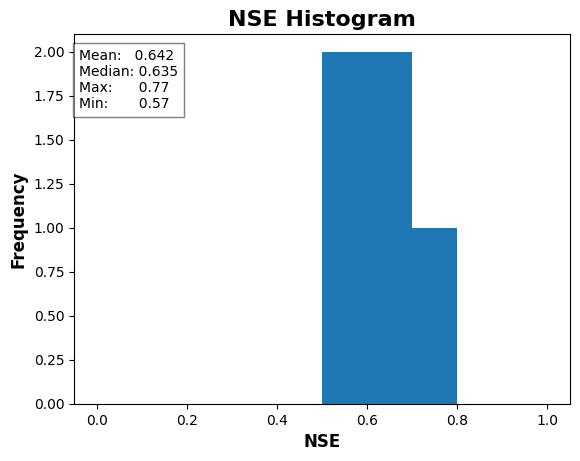

In [14]:
# Plot the histogram
plt.hist(df_NSE["NSE"], bins=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

# Add NSE statistics to the plot
plt.text(0.01, 0.8, f'Mean: {"%.3f" % df_NSE["NSE"].mean():>7}\nMedian: {"%.3f" % df_NSE["NSE"].median():>0}\nMax: {"%.2f" % df_NSE["NSE"].max():>9}\nMin: {"%.2f" % df_NSE["NSE"].min():>10}',
         transform=plt.gca().transAxes, bbox=dict(facecolor="white", alpha=0.5))

# Format plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.xlabel("NSE", fontsize=12, fontweight="bold")
plt.ylabel("Frequency", fontsize=12, fontweight="bold")
plt.title("NSE Histogram", fontsize=16, fontweight="bold")
#plt.savefig(save_folder+"/NSE_LSTM_Histogram.png", bbox_inches="tight", pad_inches=0)
plt.show()

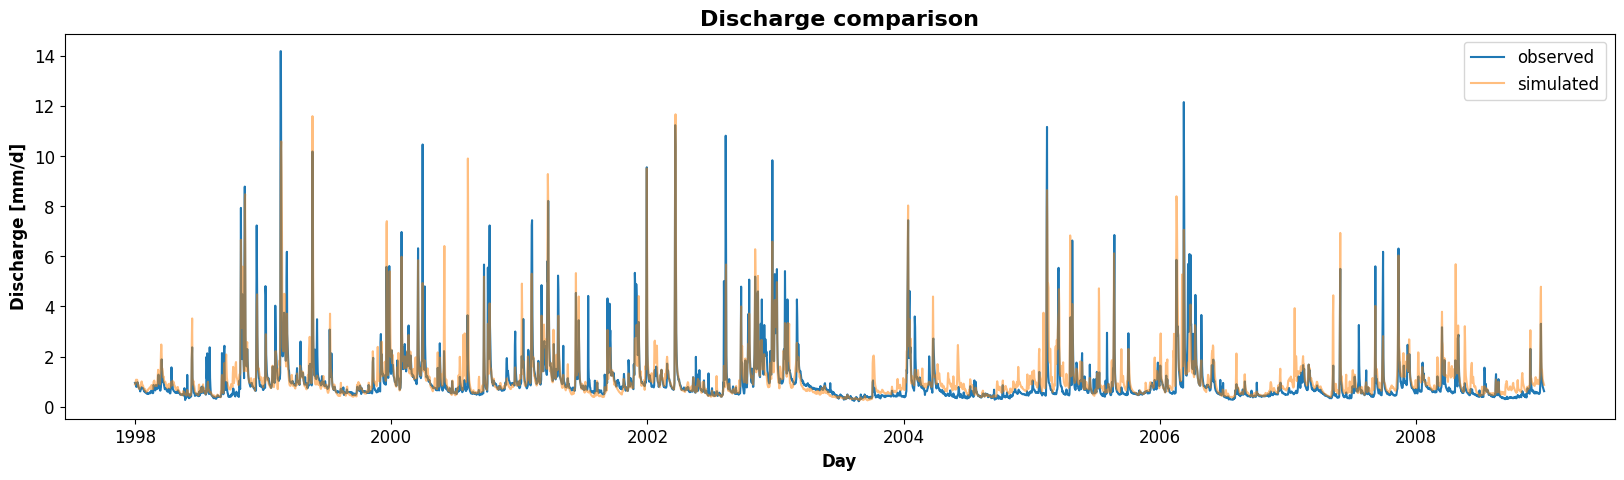

In [16]:
# Plot simulated and observed discharges
basin_to_analyze = "GRDC_6342660"

plt.plot(test_results[basin_to_analyze]["y_obs"], label="observed", color=color_palette["observed"])
plt.plot(test_results[basin_to_analyze]["y_sim"], label="simulated", alpha=0.5, color=color_palette["simulated"])

# Format plot
plt.xlabel("Day", fontsize=12, fontweight="bold")
plt.ylabel("Discharge [mm/d]", fontsize=12, fontweight="bold")
plt.title("Discharge comparison", fontsize=16, fontweight="bold")
plt.tick_params(axis="both", which="major", labelsize=12)
plt.legend(loc="upper right",fontsize=12)
#plt.savefig(save_folder+"/Model_Comparison.png", bbox_inches="tight", pad_inches=0)